# Roads as Vectors

This notebook demonstrates converting the roads raster that is the output of the Analaytics feed into a vector dataset.

It demonstrates the following techniques for converting to vector:
1. GDAL CLI
2. Rasterio (no processing)
3. Rasterio (with filtering and simplification)

In [1]:
import os

import fiona
import matplotlib.pyplot as plt
from planet import api
import rasterio
from rasterio import features as rfeatures
from rasterio.enums import Resampling
from rasterio.plot import show
import shapely
from shapely.geometry import shape as sshape

In [2]:
# if your Planet API Key is not set as an environment variable, you can paste it below
API_KEY = os.environ.get('PL_API_KEY', 'PASTE_YOUR_KEY_HERE')

analytics_client = api.ClientV1(api_key=API_KEY)

## Obtain Analytics Raster

### Identify road feed feature for download

We want to download the most recent feature from the feed for road detection in Kirazli, Turkey.

In [3]:
# This ID is for a subscription for monthly road detection in Kirazli, Turkey
SUBSCRIPTION_ID = 'f184516c-b948-406f-b257-deaa66c3f38a'

In [4]:
results = analytics_client.list_collection_features(SUBSCRIPTION_ID).get()
features = results['features']
print('{} features in collection'.format(len(features)))

96 features in collection


In [5]:
# sort features by acquisition date
features.sort(key=lambda k: k['properties']['first_acquired'])
feature = features[-1]
print(feature['properties']['first_acquired'])

2019-07-01T00:00:00Z


### Download Quad Raster

In [6]:
RESOURCE_TYPE = 'target-quad'

In [7]:
def create_save_dir(root_dir='data'):
    save_dir = root_dir

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    return save_dir

dest = 'data'
create_save_dir(dest)

'data'

We want to save each all of the images in one directory. But all of the images for a single target quad have the same name, L15_{target_quad_id}. We use the function write_to_file to save the image, and that function pulls the name from the resource name attribute, which we can't set. So, we are going to make a new object that functions just like resource, but has the name attribute set to the acquisition date. It would be nice if the write_to_file function just allowed us to set the name, like it allows us to set the directory.

In [8]:
from planet.api.models import Body
from planet.api.utils import write_to_file

def download_feature(feature, subscription_id, resource_type, dest=dest):
    print('{}: acquired {}'.format(feature['id'], get_date(feature)))
    resource = analytics_client.get_associated_resource_for_analytic_feature(subscription_id,
                                                                             feature['id'],
                                                                             resource_type)
    
    named_resource = NamedBody(resource, get_name(feature))
    filename = download_resource(named_resource, dest)
    return filename

def get_date(feature):
    feature_acquired = feature['properties']['first_acquired']
    return feature_acquired.split('T',1)[0]

def get_name(feature):
    return feature['properties']['target_quad_id'] + '_' + get_date(feature) + '.tif'

def download_resource(resource, dest, overwrite=False):
    writer = write_to_file(dest, overwrite=overwrite)
    writer(resource)
    filename = os.path.join(dest, resource.name)
    print('file saved to: {}'.format(filename))
    return filename

class NamedBody(Body):
    def __init__(self, body, name):
        super(NamedBody, self).__init__(body._request, body.response, body._dispatcher)
        self._name = name
        
    @property
    def name(self):
        return self._name

In [9]:
filename = download_feature(feature, SUBSCRIPTION_ID, RESOURCE_TYPE)

afb9e074-b180-4e11-9524-eb9bd4def5c5: acquired 2019-07-01
file saved to: data/1176-1272_2019-07-01.tif


### Visualize Roads Image

The output of the analytics road detection is a boolean image where road pixels are given a value of True and non-road pixels are given a value of False.

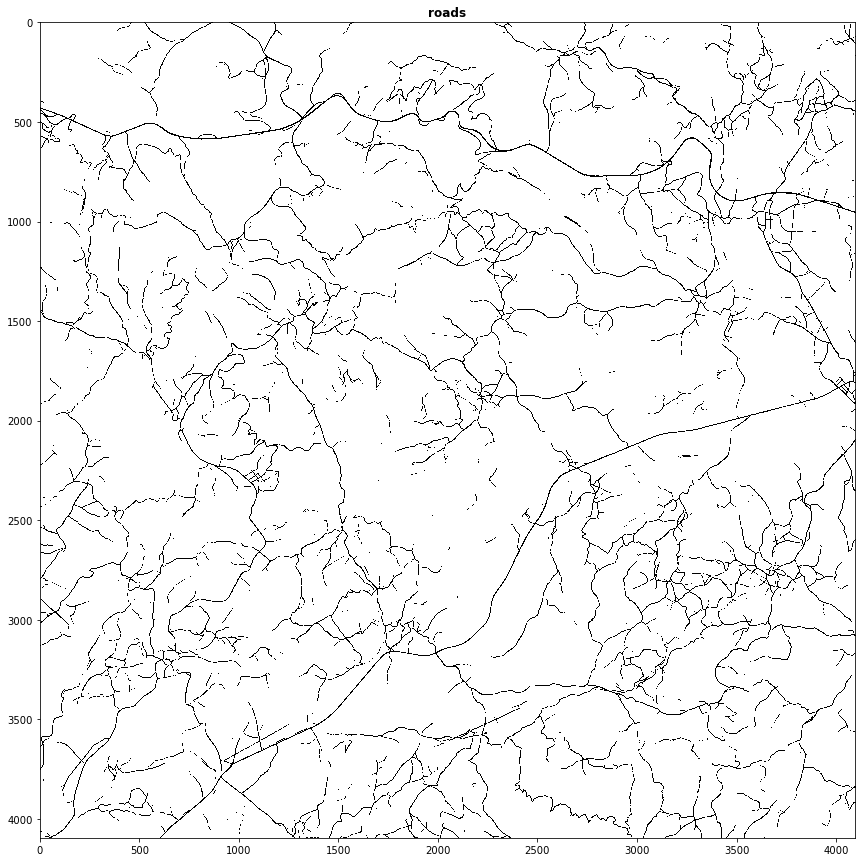

In [10]:
def _open(filename, factor=1):
    with rasterio.open(filename) as dataset:
        height = int(dataset.height / factor)
        width = int(dataset.width / factor)
        data = dataset.read(
            out_shape=(dataset.count, height, width)
        )
    return data

def open_bool(filename, factor=1):
    data = _open(filename, factor=factor)
    return data[0,:,:]

def get_figsize(factor):
    return tuple(2 * [int(25/factor)])



factor = 1
figsize = (15, 15)

roads = open_bool(filename, factor=factor)
fig = plt.figure(figsize=figsize)
show(roads, title="roads", cmap="binary")

## Convert Roads to Vector Features

### GDAL Command-Line Interface (CLI)

GDAL provides a python script that can be run via the CLI. It is quite easy to run and fast, though it doesn't allow for some of the convenient pixel-space filtering and processing that rasterio provides and we will use later on.

In [11]:
gdal_output_filename = os.path.join('data', 'test_gdal.shp')

In [12]:
!gdal_polygonize.py $filename $gdal_output_filename

Creating output data/test_gdal.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.


### Rasterio - no filtering

In this section we use rasterio to convert the binary roads raster into a vector dataset. The vectors are written to disk as a shapefile. The shapefile can be imported into geospatial programs such as QGIS or ArcGIS for visualization and further processing.

This is basic conversion to vector shapes. No filtering based on size (useful for removing small 1 or 2 pixel road segments), smoothing to remove pixel edges, or conversion to the road centerlines is performed here. These additional 'features' will be provided in sections below this one in the future.

In [13]:
def roads_as_vectors(filename): 
    with rasterio.open(filename) as dataset:
        roads = dataset.read(1)
        road_mask = roads == 255 # mask non-road pixels

        # transforms roads features to image crs
        road_shapes = rfeatures.shapes(roads, mask=road_mask, connectivity=8, transform=dataset.transform)
        road_geometries = (r for r, _ in road_shapes)
        
        crs = dataset.crs
    return (road_geometries, crs)

def save_as_shapefile(output_filename, geometries, crs):
    driver='ESRI Shapefile'
    schema = {'geometry': 'Polygon', 'properties': []}
    with fiona.open(output_filename, mode='w', driver=driver, schema=schema, crs=crs) as c:
        count = 0
        for g in geometries:
            count += 1;
            c.write({'geometry': g, 'properties': {}})
        print('wrote {} geometries to {}'.format(count, output_filename))

        
road_geometries, crs = roads_as_vectors(filename)
output_filename = os.path.join('data', 'test.shp')
save_as_shapefile(output_filename, road_geometries, crs)

wrote 1507 geometries to data/test.shp


### Rasterio - Filtering and Simplifying

In this section, we use `shapely` to filter the road vectors by size and simplify them so we don't have a million pixel edges.

In [14]:
def roads_as_vectors_with_filtering(filename, min_pixel_size=5): 
    with rasterio.open(filename) as dataset:
        roads = dataset.read(1)
        road_mask = roads == 255 # mask non-road pixels

        # we skip transform on vectorization so we can perform filtering in pixel space
        road_shapes = rfeatures.shapes(roads, mask=road_mask, connectivity=8)
        road_geometries = (r for r, _ in road_shapes)
        geo_shapes = (sshape(g) for g in road_geometries)

        # filter to shapes bigger than min_pixel_size
        geo_shapes = (s for s in geo_shapes if s.area > min_pixel_size)
    
        # simplify so we don't have a million pixel edge points
        tolerance = 1 #1.5
        geo_shapes = (g.simplify(tolerance, preserve_topology=False)
                      for g in geo_shapes)

        # apply image transform    
        # rasterio transform: (a, b, c, d, e, f, 0, 0, 1), c and f are offsets
        # shapely: a b d e c/xoff f/yoff
        d = dataset.transform
        shapely_transform = [d[0], d[1], d[3], d[4], d[2], d[5]]
        proj_shapes = (shapely.affinity.affine_transform(g, shapely_transform)
                       for g in geo_shapes)
        
        road_geometries = (shapely.geometry.mapping(s) for s in proj_shapes)
        
        crs = dataset.crs
    return (road_geometries, crs)

In [15]:
road_geometries_filt, crs = roads_as_vectors_with_filtering(filename)
output_filename = os.path.join('data', 'test_filt.shp')
save_as_shapefile(output_filename, road_geometries_filt, crs)

wrote 838 geometries to data/test_filt.shp
